## 1. Import libraries

In [1]:
import rasterio
import numpy as np
import random
import os
import torch
import pandas as pd
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from loss_fn import FocalDiceLoss, iou_pytorch

## 2. Config

In [2]:
config={
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'seed':10,
    'val_size':0.3,
    'channels':[6,5,2],
    'experiment':True,
    'batch_size':8,
    'lr':1e-3,
    'epochs':50,
    'early_stopping':15,
    'inference':{
        'threshold':0.25
    }
}
DATAPATH='./dataset'
data_paths={
    'train_csv': DATAPATH+'/train_meta_exp.csv',
    'test_csv': DATAPATH+'/test_meta_exp.csv',
    'train_img':DATAPATH+'/train_img/',
    'train_mask':DATAPATH+'/train_mask/',
    'test_img':DATAPATH+'/test_img/',
}
train_csv = pd.read_csv(data_paths['train_csv'])
SAVE_PATH = './logs'
save_paths={
    'model':SAVE_PATH+'/models/',
    'val':SAVE_PATH+'/vals/'
}
# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
fix_seed(config['seed'])

## 3. Load Data

In [3]:
class Wildfire_Dataset(Dataset):
    def __init__(self, csv, transform_f=None,infer=False):
        self.csv = csv
        self.transform_f = transform_f
        self.infer = infer
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self,idx):
        img_path = self.csv.iloc[idx,0]
        # test인 경우 infer==True
        if self.infer:
            image = rasterio.open(data_paths['test_img']+img_path).read().transpose(1,2,0)[:,:,config['channels']]
            image = image/(2**16)
            if self.transform_f:
                image = self.transform_f(image=image)['image']
            return image
        # train인 경우
        image = rasterio.open(data_paths['train_img']+img_path).read().transpose(1,2,0)[:,:,config['channels']]
        image = image/(2**16)
        mask_path = self.csv.iloc[idx,1]
        mask = rasterio.open(data_paths['train_mask']+mask_path).read().transpose(1,2,0)
        if self.transform_f:
            augmented = self.transform_f(image=image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask

In [4]:
base_transforms = {
    'train': A.Compose([
        # A.RandomBrightnessContrast(contrast_limit=(2,2),p=1),
        A.Normalize((0.5, ), (0.5, )),
        ToTensorV2(transpose_mask=True)
    ]),
    'valid':A.Compose([
        A.Normalize((0.5, ), (0.5, )),
        ToTensorV2(transpose_mask=True)
    ]),
    'test':A.Compose([
        A.Normalize((0.5, ), (0.5, )),      
        ToTensorV2(transpose_mask=True)
    ]),
}

In [5]:
fix_seed(config['seed'])
train_csv_, valid_csv_ = train_test_split(train_csv,test_size=config['val_size'],random_state=config['seed'])
train_dataset = Wildfire_Dataset(train_csv_,transform_f=base_transforms['train'],infer=False)
valid_dataset = Wildfire_Dataset(valid_csv_,transform_f=base_transforms['valid'],infer=False)
# B,C,H,W

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'],shuffle=False)
print(f'train size: {len(train_dataset)}, valid size: {len(valid_dataset)}')

train size: 14, valid size: 6


Augmentation Result Viewer

In [ ]:
num_imgs_to_show=4
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('label')

cnt=0
for idx,(imgs, masks) in enumerate(train_loader):
    for i in range(len(imgs)):
        for j in range(len(config['channels'])):
            axs[i,j].imshow(imgs[i,j,:,:],cmap='gray')
        axs[i,-1].imshow(masks[i,0,:,:],cmap='gray')
        axs[i,-1].set_xlabel(str(masks[i,0,:,:].sum().sum()))
        cnt+=1
        if cnt==num_imgs_to_show:
            break
    if cnt==num_imgs_to_show:
        break

## 4. Modeling

In [6]:
import segmentation_models_pytorch as smp
# from fcn_model import FCN

C:\Users\artis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
fix_seed(config['seed'])
model = smp.Unet(
    encoder_name='efficientnet-b0',
    encoder_weights = 'imagenet',
    in_channels=len(config['channels']),
    classes=1,
)
# model = FCN()
torch.save(model.state_dict(), save_paths["model"]+'/base_model.pt')

## 5. Train/Validation

In [8]:
def validation(config, model, criterion, valid_loader,epoch):
    model.eval()
    valid_loss=0
    valid_iou_score = 0
    valid_focal = 0
    valid_dice = 0
    
    y_pred_dict={}
    with torch.no_grad():
        for idx,(images, masks) in tqdm(enumerate(valid_loader)):
            images = images.to(config['device'],dtype = torch.float32)
            masks = masks.to(config['device'],dtype = torch.float32)
            
            outputs = model(images)
            dice_loss,focal_loss,loss = criterion(outputs, masks)

            valid_dice += dice_loss
            valid_focal += focal_loss
            valid_iou_score += iou_pytorch(outputs,masks,threshold=config['inference']['threshold'])
            valid_loss += loss.item()
            
            for i in range(len(outputs)):
                y_pred = np.where(outputs[i,0,:,:].to('cpu')>config['inference']['threshold'],1,0).astype(np.uint8)
                y_pred_dict[str(idx*config['batch_size']+i)] = y_pred
        valid_save_path = save_paths['val']+f'epoch_{epoch}.pkl'
        joblib.dump(y_pred_dict,valid_save_path)
    return valid_loss/len(valid_loader), valid_iou_score/len(valid_loader), valid_dice/len(valid_loader),valid_focal/len(valid_loader)

In [11]:
def train(config, model, train_loader, valid_loader):
    model = model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None
    
    # criterion = FocalLoss()
    criterion = FocalDiceLoss()
    
    optimizer = torch.optim.Adam(model.parameters(),lr = config['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-8, verbose=True)
    print('***TRAINING START***')
    for epoch in range(config['epochs']):
        model.train()
        epoch_loss=0
        epoch_iou = 0
        epoch_dice=0
        epoch_focal =0
        for images, masks in tqdm(train_loader):
            images = images.to(config['device'],dtype = torch.float32)
            masks = masks.to(config['device'],dtype = torch.float32)
            
            optimizer.zero_grad()
            outputs = model(images)
            dice_loss,focal_loss,loss = criterion(outputs, masks)
            loss.backward()
            epoch_iou += iou_pytorch(outputs,masks,threshold=config['inference']['threshold'])
            epoch_dice += dice_loss
            epoch_focal += focal_loss
            optimizer.step()
            
            epoch_loss+=loss.item()
        
        val_loss,val_iou,val_dice,val_focal = validation(config, model, criterion, valid_loader, epoch)
        
        es_count += 1
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = model
            state_dict = model.state_dict()
            best_epoch = epoch+1
            print(f"Epoch [{best_epoch}] New Minimum Valid Loss!")
            print("..save current best model..")
            model_name = f'epoch {epoch}_current_best_model.pt'
            torch.save(state_dict, save_paths['model']+'/'+model_name)
        
        scheduler.step(val_loss)
        
        if es_count == config['early_stopping']:
            print(f"Early Stopping Count에 도달했습니다!")
            print(f"Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Train IoU: {epoch_iou/len(train_loader):6f}, Train Dice: {epoch_dice/len(train_loader):6f}, Train Focal: {epoch_focal/len(train_loader):6f}\nValid Loss: {val_loss:6f}, Valid_iou: {val_iou:6f}, Valid_dice: {val_dice:6f}, Valid_focal: {val_focal:6f}, Best Epoch: {best_epoch}")
            print("***TRAINING DONE***")
            return best_model
        print(f"Epoch {epoch+1}, ES Count: {es_count}\nTrain Loss: {(epoch_loss/len(train_loader)):6f}, Train IoU: {epoch_iou/len(train_loader):6f}, Train Dice: {epoch_dice/len(train_loader):6f}, Train Focal: {epoch_focal/len(train_loader):6f}\nValid Loss: {val_loss:6f}, Valid_iou: {val_iou:6f}, Valid_Dice: {val_dice:6f}, Valid_Focal: {val_focal:6f}")
        print("------------------------------------------------------------------------------------")
    print(f"Early Stopping Count에 도달하지 않았습니다! \nEarly Stopping Count: {config['early_stopping']} Best Epoch: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [ ]:
fix_seed(config['seed']) # 결과 재현용
best_model = train(config,model,train_loader,valid_loader)

## 6. Inference

In [19]:
infer_model = smp.Unet(
    encoder_name='efficientnet-b0',
    encoder_weights = 'imagenet',
    in_channels=len(config['channels']),
    classes=1,
)
# model = FCN()
infer_model.load_state_dict(torch.load('./logs/models/epoch 5_current_best_model.pt'))

<All keys matched successfully>

In [20]:
test_csv = pd.read_csv(data_paths['test_csv'])
test_dataset = Wildfire_Dataset(test_csv,transform_f=base_transforms['test'],infer=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [21]:
def inference(model):
    model.to(config['device'])
    model.eval()
    y_pred_dict = {}
    with torch.no_grad():
        for idx,img in tqdm(enumerate(test_loader)):
            img = img.to(config['device'],dtype = torch.float32)
            
            # pytorch smp 라이브러리 모델은 predict 가능
            y_pred = model.predict(img)
            
            # 구현한 FCN은 그냥 output 찍는쪽으로
            # y_pred = model(img)

            y_pred = np.where(y_pred[0, 0, :, :].to('cpu') > config['inference']['threshold'], 1, 0) # 임계값 처리
            y_pred = y_pred.astype(np.uint8)
            y_pred_dict[idx] = y_pred

        joblib.dump(y_pred_dict, './y_pred.pkl')

In [22]:
fix_seed(config['seed'])
inference(infer_model)

0it [00:00, ?it/s]

20it [00:02,  7.40it/s]


## 7. Validation Viewer

In [23]:
epoch_to_check = 5
num_imgs_to_show = 4
valid_save_path = save_paths['val']+f'epoch_{epoch_to_check}.pkl'
val_preds = joblib.load(valid_save_path)

In [ ]:
val_preds = joblib.load(valid_save_path)
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+2)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('label')
axs[0,i+2].set_title('pred')
cnt=0
for idx,(imgs, masks) in enumerate(valid_loader):
    for i in range(len(imgs)):
        iou = iou_pytorch(torch.from_numpy(val_preds[str(idx*config['batch_size']+i)]).unsqueeze(0).unsqueeze(0),masks[i].unsqueeze(0),threshold=config['inference']['threshold'])
        for j in range(len(config['channels'])):
            axs[i,j].imshow(imgs[i,j,:,:],cmap='gray')
        axs[i,-3].set_xlabel(f'iou: {iou.item():6g}')
        axs[i,-2].imshow(masks[i,0,:,:],cmap='gray')
        axs[i,-2].set_xlabel(str(masks[i,0,:,:].sum().sum().item()))
        axs[i,4].imshow(val_preds[str(idx*config['batch_size']+i)],cmap='gray')
        axs[i,4].set_xlabel(str(val_preds[str(idx*config['batch_size']+i)].sum().sum()))
        cnt+=1
        if cnt==num_imgs_to_show:
            break
    if cnt==num_imgs_to_show:
        break

## 8. Inference Viewer

In [36]:
num_imgs_to_show = 4
test_save_path = './y_pred.pkl'
test_preds = joblib.load(test_save_path)

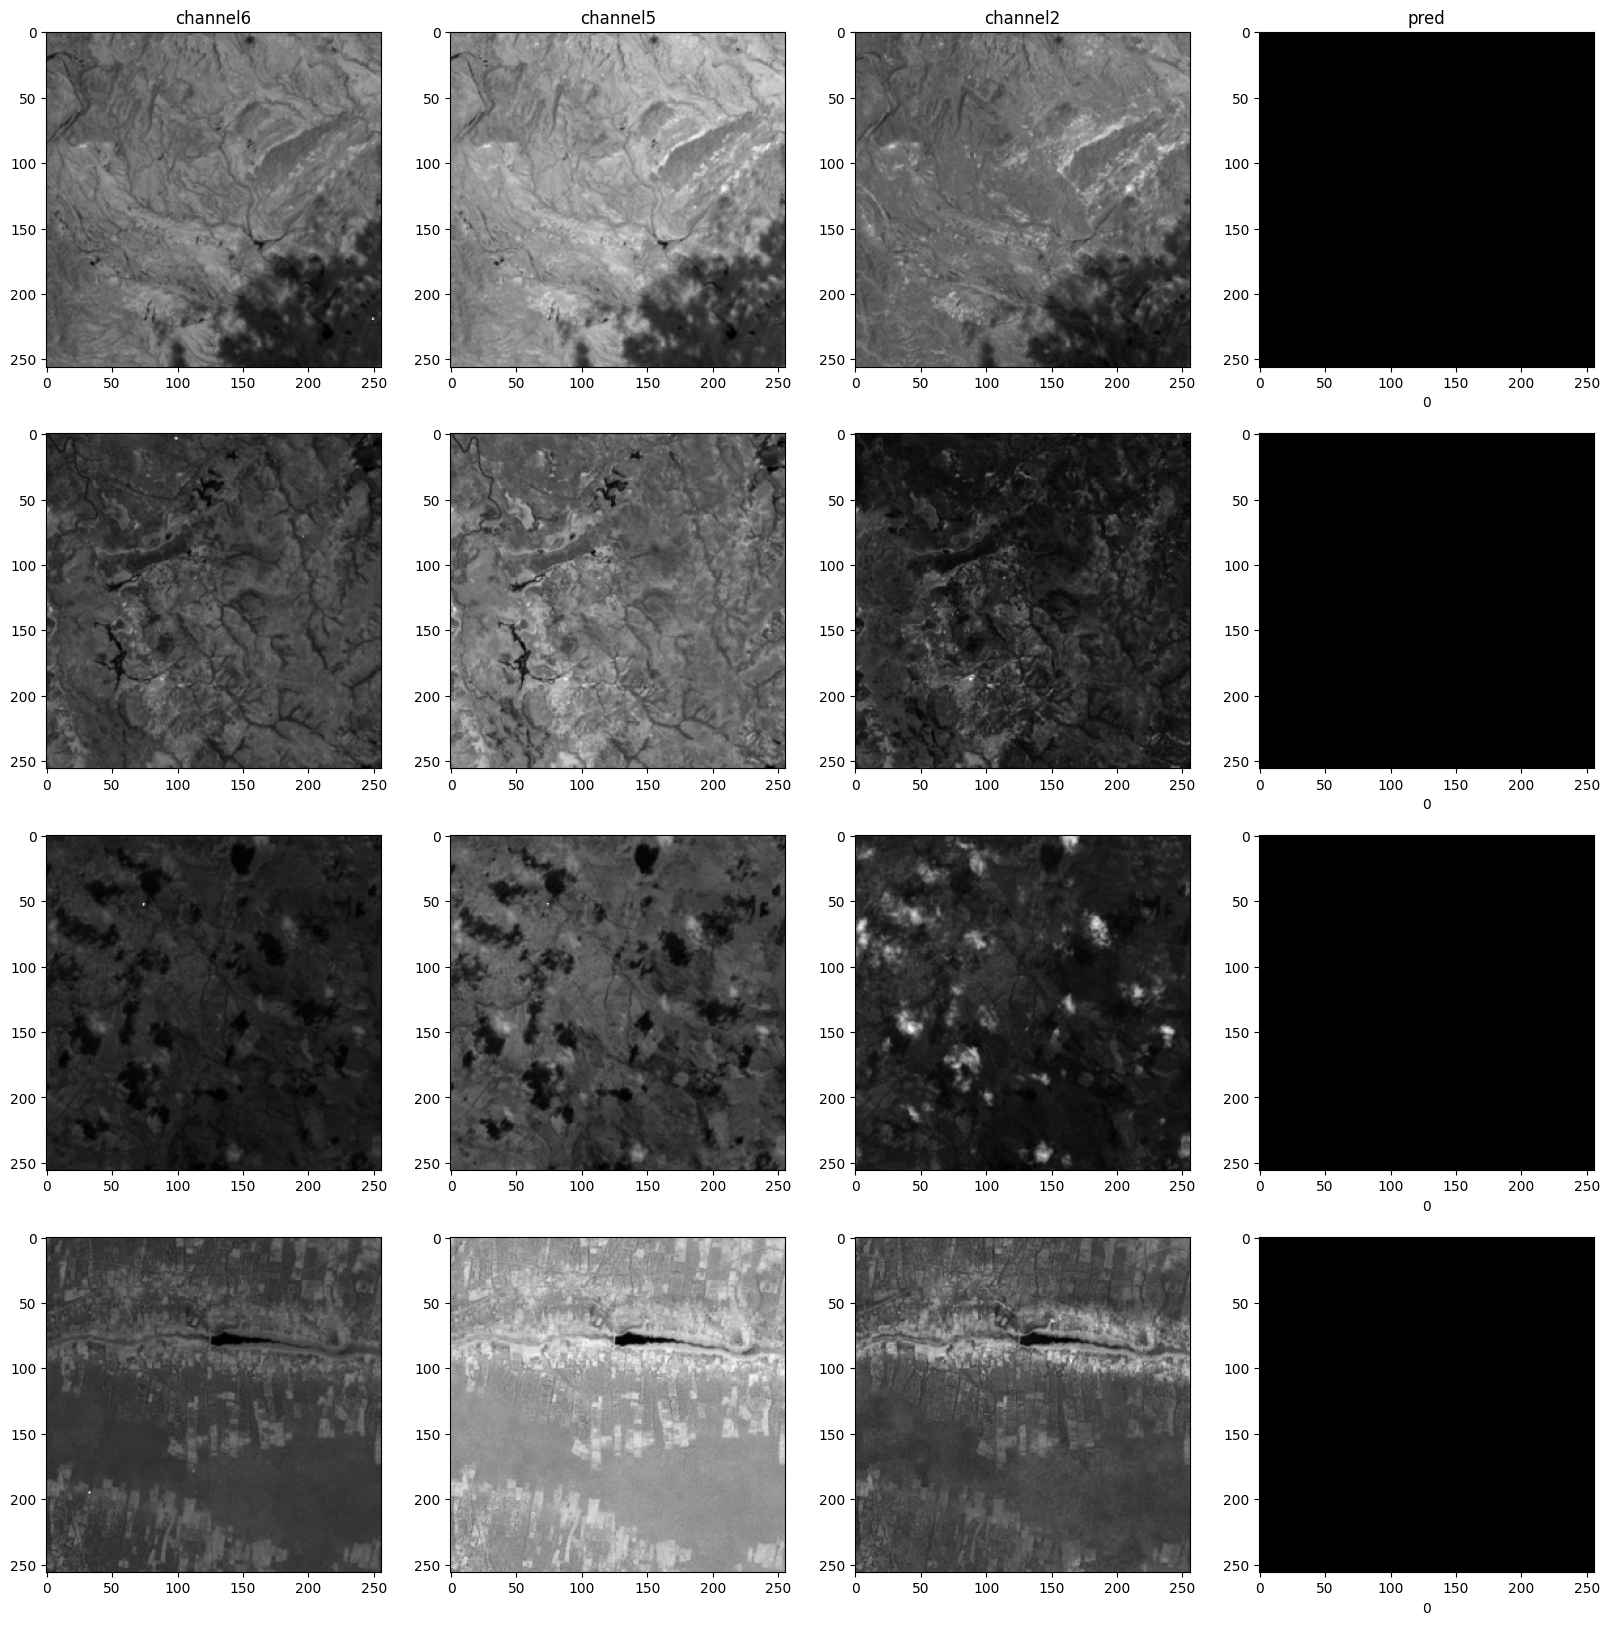

In [37]:
test_preds = joblib.load(test_save_path)
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('pred')
cnt=0
for (imgs) in (test_loader):
    for j in range(len(config['channels'])):
        axs[cnt,j].imshow(imgs[0,j,:,:],cmap='gray')
    axs[cnt,-1].imshow(test_preds[cnt],cmap='gray')
    axs[cnt,-1].set_xlabel(str(test_preds[cnt].sum().sum()))
    cnt+=1
    if cnt==num_imgs_to_show:
        break